# Defining our Area of Interest

This notebook serves as an exploration of of where we would be interested in mapping smallholder dry season irrigation. Considerations include: 
- Country boundaries
- The presence of agriculture, preferably specifically smallholder agriculture
- arid and semi-arid climate
- One clear rainy season and one clear dry season

In [10]:
import sys
import os

# Add the project root to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import numpy as np
import rasterio
from src.utils.utils import save_data, get_data_root
from shapely.geometry import box
import matplotlib.pyplot as plt

/var/folders/1f/_ptk0jz93h39qj25crwwtb0w0000gn/T/ipykernel_70209/787589935.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

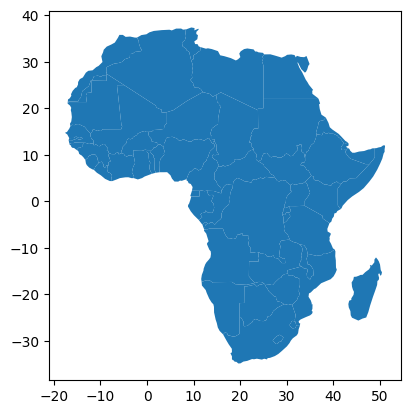

In [3]:
# Load county boundaries and only keep those in Sub-Saharan Africa

import geopandas as gpd

# Load country boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for Africa
africa = world[world['continent'] == 'Africa']

# Display the filtered data
africa

# Plot the filtered data
africa.plot()

<Axes: >

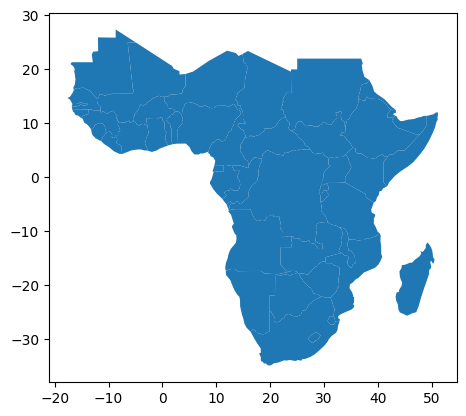

In [4]:
# Filter to Sub-Saharan Africa

northern_africa_countries = ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia', 'W. Sahara']

ssa = africa[~africa['name'].isin(northern_africa_countries)]

# Display the filtered data
ssa.plot()

In [5]:
# save the filtered data

save_data(ssa, 'sampling/ssa_counties.json', "countries in Sub-Saharan Africa")

# Create and save a simple bounding box for Sub-Saharan Africa

# Get the bounding box of the GeoDataFrame
ssa_bbox = ssa.total_bounds  # [minx, miny, maxx, maxy]

# Create a bounding box polygon
bbox_polygon = box(ssa_bbox[0], ssa_bbox[1], ssa_bbox[2], ssa_bbox[3])

# Convert the bounding box to a GeoDataFrame
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=ssa.crs)

save_data(bbox_gdf, 'sampling/ssa_bbox.json', "bounding box for Sub-Saharan Africa")



In [6]:
# How many km2 are there in sub-saharan africa? 

# Calculate the area of Sub-Saharan Africa
ssa.to_crs(epsg=6933).area.sum() / 10**6  # in km^2

# About 24 million. 

24149688.441414084

In [8]:
# Check out regions that are agriculture

with rasterio.open(get_data_root() + '/sampling/raw/af-croplands-geotif/af_cropland.tif') as src:
    cropland_data = src.read(1)
    
    # Convert to binary (0s and 1s) based on the threshold > 0
    cropland_binary = (cropland_data > 0).astype(np.uint8)

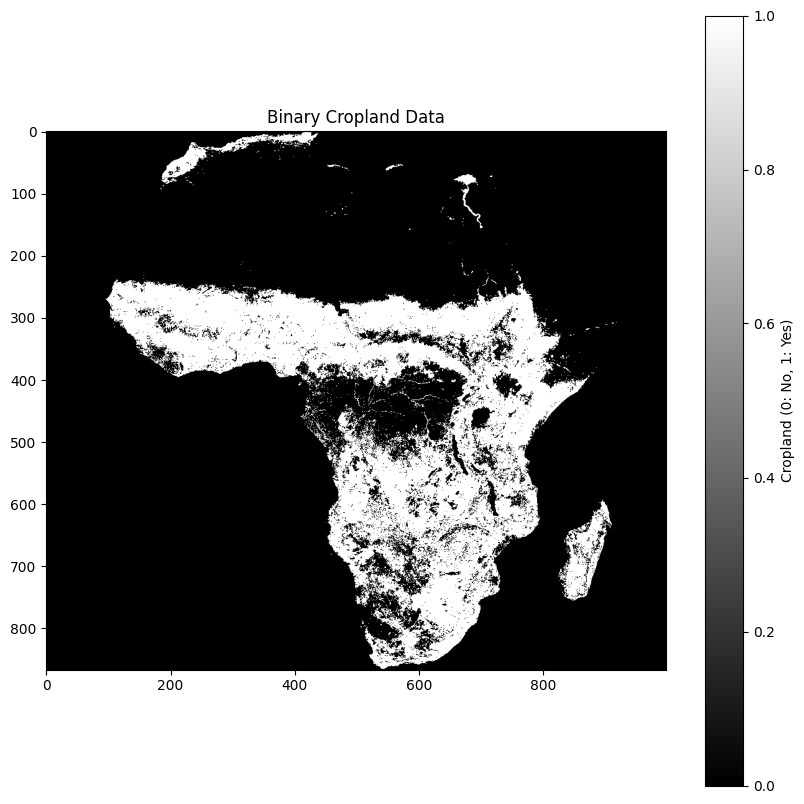

In [ ]:
# Plot the binary cropland data
plt.figure(figsize=(10, 10))
plt.imshow(cropland_binary, cmap='gray')
plt.title('Binary Cropland Data')
plt.colorbar(label='Cropland (0: No, 1: Yes)')
plt.show()

# probably better: "https://search.earthdata.nasa.gov/search/granules?p=C2763261633-LPCLOUD&pg[0][v]=f&pg[0][gsk]=-start_date&q=C2763261633-LPCLOUD&tl=1738803151.687!3!!&lat=-2.110055565513534&long=-33.890625"

In [13]:
# Determine seasonality and only keep places with a clear dry season. Also map out when the dry season starts and how long it lasts. 

# First download 12 months of chirps climatological precip data

data_site = "https://data.chc.ucsb.edu/products/CHPclim/90N-90S.landonly/monthly/"

for month in range(1, 13):
    month_str = str(month).zfill(2)
    file_name = f"CHPclim.{month_str}.tif"
    os.system(f"wget {data_site}{file_name} -P {get_data_root()}/sampling/raw/chirps_climatology")

--2025-02-05 17:31:59--  https://data.chc.ucsb.edu/products/CHPclim/90N-90S.landonly/monthly/CHPclim.01.tif
wget: /Users/annaboser/.netrc:1: unknown token "“machine"
wget: /Users/annaboser/.netrc:1: unknown token "urs.earthdata.nasa.gov"
wget: /Users/annaboser/.netrc:1: warning: ‘login’ token appears before any machine name
wget: /Users/annaboser/.netrc:1: warning: ‘password’ token appears before any machine name
Resolving data.chc.ucsb.edu (data.chc.ucsb.edu)... 128.111.100.31
Connecting to data.chc.ucsb.edu (data.chc.ucsb.edu)|128.111.100.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103709376 (99M) [image/tiff]
Saving to: ‘/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/data/sampling/raw/chirps_climatology/CHPclim.01.tif’

     0K .......... .......... .......... .......... ..........  0% 16.7M 6s
    50K .......... .......... .......... .......... ..........  0% 5.78M 11s
   100K .......... .......... .......... .......... .......... 

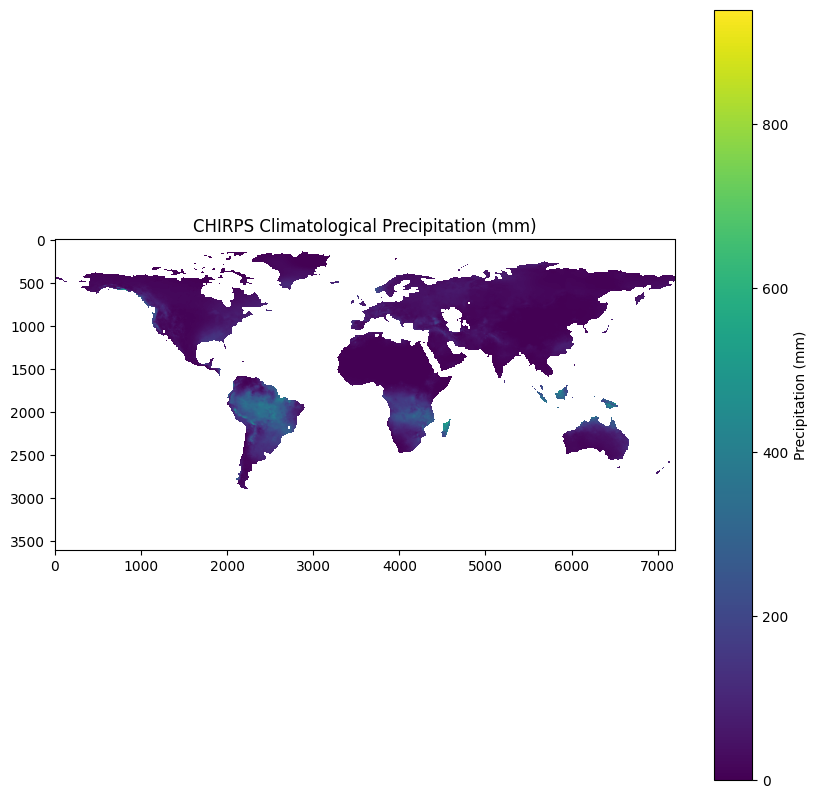

In [24]:
# Plot the first month of the data

with rasterio.open(get_data_root() + '/sampling/raw/chirps_climatology/CHPclim.01.tif') as src:

    chirps_data = src.read(1)
    
    crs = src.crs  # Coordinate Reference System
    transform = src.transform  # Affine transformation matrix
    bounds = src.bounds  # Bounding box of the raster

    # Mask out the no data values
    chirps_data = np.ma.masked_where(chirps_data == -9999, chirps_data)
    
    # Plot the data
    plt.figure(figsize=(10, 10))
    plt.imshow(chirps_data, cmap='viridis')
    plt.title('CHIRPS Climatological Precipitation (mm)')
    plt.colorbar(label='Precipitation (mm)')
    plt.show()

In [32]:
data_dir = f"{get_data_root()}/sampling/raw/chirps_climatology"

from rasterio.mask import mask
import geopandas as gpd
import numpy as np

# Function to trim CHIRPS data to SSA and return the trimmed data
def trim_to_ssa(input_tif, ssa_geom):
    with rasterio.open(input_tif) as src:
        out_image, _ = mask(src, ssa_geom.geometry, crop=True)
    return out_image[0]  # Return the first band

# Determine areas with a clear dry season
def identify_dry_season():
    monthly_precip = []
    for month in range(1, 13):
        month_str = str(month).zfill(2)
        file_name = f"CHPclim.{month_str}.tif"
        input_tif = os.path.join(data_dir, file_name)
        trimmed_data = trim_to_ssa(input_tif, ssa)
        monthly_precip.append(trimmed_data)

    # Stack monthly data (12, height, width)
    precip_stack = np.stack(monthly_precip)

    # Criteria: A clear dry season has at least 3 consecutive months with < 20 mm precipitation
    dry_season_mask = np.apply_along_axis(
        lambda x: np.any(np.convolve(x < 20, np.ones(3, dtype=int), mode='valid') == 3),
        axis=0,
        arr=precip_stack
    )

    return dry_season_mask

# Identify dry season mask
dry_season_mask = identify_dry_season()

Text(0.5, 1.0, 'Dry Season Mask')

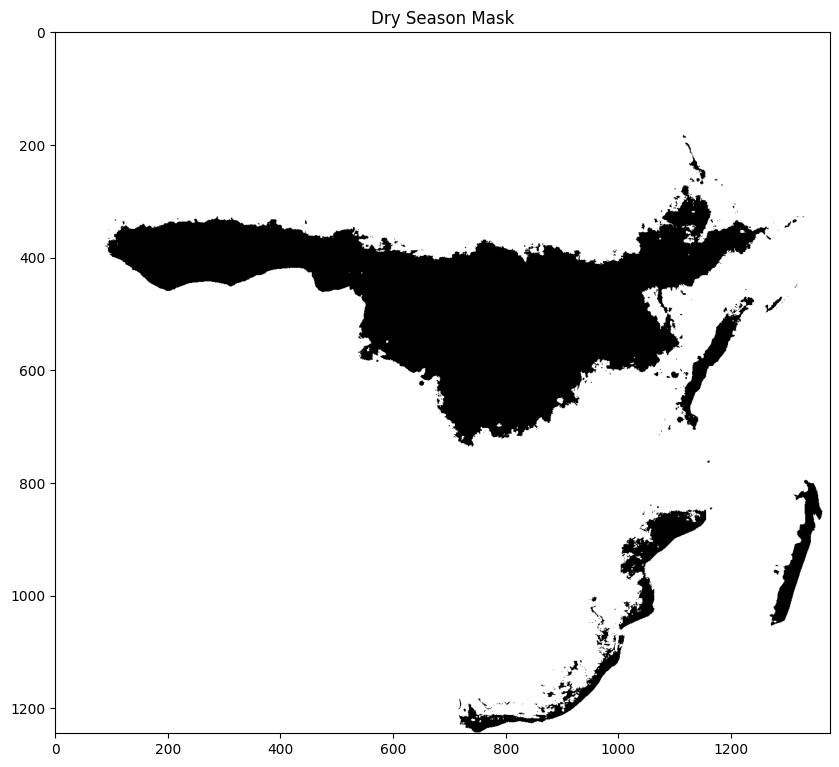

In [33]:
# plot the dry season mask with ssa boundaries on top

plt.figure(figsize=(10, 10))
plt.imshow(dry_season_mask, cmap='gray')
plt.title('Dry Season Mask')